In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 89.csv
📊 데이터 Shape: I=4, T=24, S=5
✅ 시뮬레이션 초기화 완료: S=5, Randomness='high', M1=618.95, M2=1297.72


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:96: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 1325 rows, 989 columns and 3125 nonzeros
Model fingerprint: 0x02a64196
Variable types: 629 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [9e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 1e+03]
Found heuristic solution: objective 850072.08983
Presolve removed 235 rows and 95 columns
Presolve time: 0.00s
Presolved: 1090 rows, 894 columns, 2750 nonzeros
Variable types: 569 continuous, 325 integer (325 binary)

Root relaxation: objective 1.189586e+06, 447 iterations, 0.00 seconds (0.00 work un

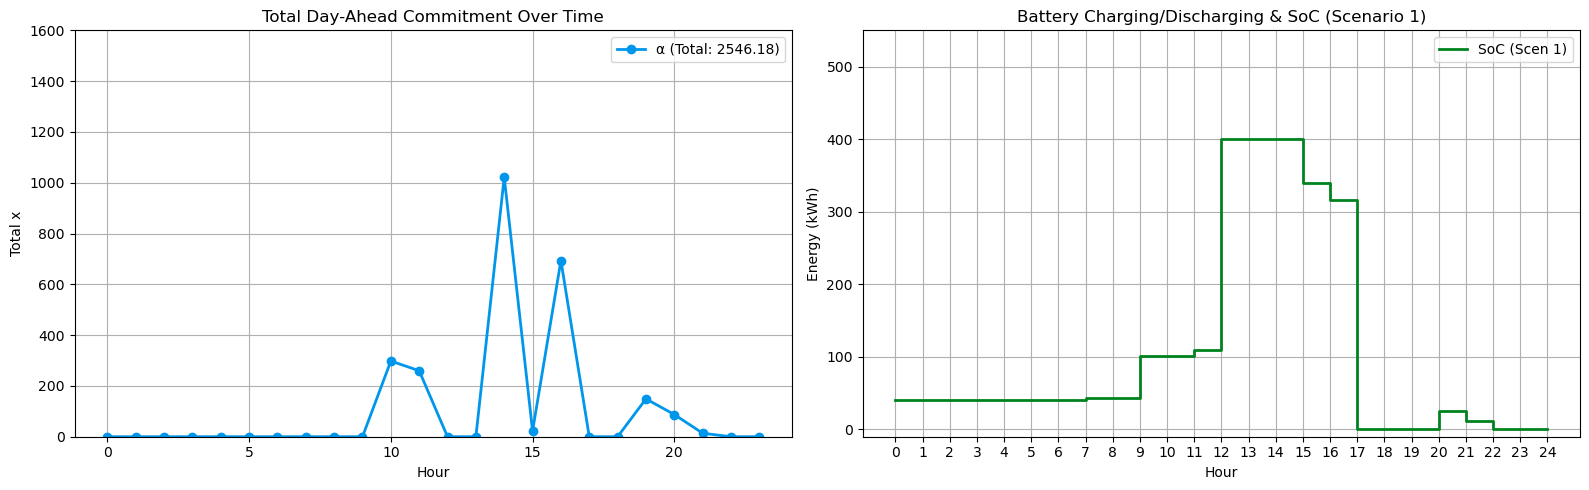

In [2]:
agg = gp.Model("agg")
agg.setParam("MIPGap", 1e-7)

a = agg.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = agg.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = agg.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = agg.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = agg.addVars(T, S, vtype=GRB.BINARY, name="mu")

agg.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum(1 / S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s])
                  for t, s in product(range(T), range(S)))

agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(bp[t, s] <= gp.quicksum(R[i, t, s] for i in range(I)))
    agg.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gd[t, s] <= g[t, s])
    agg.addConstr(gc[t, s] <= sum(K) - g[t, s])
    agg.addConstr(bp[t, s] <= M2 * mu[t, s])
    agg.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    agg.addConstr(bm[t, s] <= M2 * eta[t, s])
    agg.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    agg.addConstr(gc[t, s] <= M2 * lam[t, s])
    agg.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    agg.addConstr(g[0, s] == sum(K0))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

a_vals = np.array([a[t].X for t in range(T)])
bp_vals = np.array([[bp[t, s].X for s in range(S)] for t in range(T)])
bm_vals = np.array([[bm[t, s].X for s in range(S)] for t in range(T)])
g_vals  = np.array([[g[t, s].X  for s in range(S)] for t in range(T+1)])
gc_vals = np.array([[gc[t, s].X for s in range(S)] for t in range(T)])
gd_vals = np.array([[gd[t, s].X for s in range(S)] for t in range(T)])

plot_summary(agg, P_DA, P_RT, P_PN, a_vals, bp_vals, bm_vals, g_vals, s=1)

In [3]:
for s in range(1, 2):
    for t in range(T):
        sum_R = R[:, t, s].sum()
        alpha_val = a[t].X
        bp_val = bp[t, s].X
        bm_val = bm[t, s].X
        gc_val = gc[t, s].X
        gd_val = gd[t, s].X
        g_val = g[t, s].X

        lhs = sum_R - alpha_val
        rhs = bp_val - bm_val + gc_val - gd_val

        print(f"✅[t={t:02d}, s={s:02d}]  ∑R={sum_R:.2f}, α={alpha_val:.2f}, β⁺={bp_val:.2f}, β⁻={bm_val:.2f}, γᶜ={gc_val:.2f}, γᴰ={gd_val:.2f}, γ={g_val:.2f}")
        # print(f"              LHS = {lhs:.2f}, RHS = {rhs:.2f}")

✅[t=00, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=40.00
✅[t=01, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=40.00
✅[t=02, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=40.00
✅[t=03, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=40.00
✅[t=04, s=01]  ∑R=0.79, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.79, γᴰ=0.00, γ=40.00
✅[t=05, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=40.79
✅[t=06, s=01]  ∑R=2.64, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=2.64, γᴰ=0.00, γ=40.79
✅[t=07, s=01]  ∑R=7.53, α=0.00, β⁺=7.53, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=43.43
✅[t=08, s=01]  ∑R=57.53, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=57.53, γᴰ=0.00, γ=43.43
✅[t=09, s=01]  ∑R=111.71, α=0.00, β⁺=111.71, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=100.96
✅[t=10, s=01]  ∑R=562.23, α=298.04, β⁺=256.17, β⁻=0.00, γᶜ=8.01, γᴰ=0.00, γ=100.96
✅[t=11, s=01]  ∑R=550.89, α=259.86, β⁺=0.00, β⁻=0.00, γᶜ=291.03, γᴰ=0.00, γ=108.97
✅[t=12, s=01]  ∑R=579.31, α=0.00, β⁺=579.31, β⁻=0.00, γᶜ=0.00, γᴰ=0